In [1]:
import pandas as pd 
import os
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime
import re, html, copy
import seaborn as sns

In [3]:
data_dir = '/media/dmlab/My Passport/DATA/BenchmarkDataset/Cashtag Piggybacking dataset'
tweet_filepath = os.path.join(data_dir, 'tweets.csv')
user_filepath = os.path.join(data_dir, 'users.csv')

save_dir = '/media/dmlab/My Passport/DATA/CABERT/ft_data'
if not os.path.exists(save_dir): os.makedirs(save_dir)

# Tweets
User information

In [5]:
user_df = pd.read_csv(user_filepath, error_bad_lines=False)
print('human', len(user_df[user_df['bot']==0]))
print('bot', len(user_df[user_df['bot']==1]))

human_user_ids = user_df[user_df['bot']==0]['id'].values
bot_user_ids = user_df[user_df['bot']==1]['id'].values

b'Skipping line 369555: expected 16 fields, saw 17\n'
b'Skipping line 509344: expected 16 fields, saw 17\n'
/home/dmlab/anaconda3/envs/torchtext/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


human 7479
bot 18509


In [6]:
%%time
tweet_df = pd.read_csv(tweet_filepath)

CPU times: user 17.2 s, sys: 1.97 s, total: 19.2 s
Wall time: 19.2 s


In [7]:
print('Total number of tweets={}'.format(len(tweet_df)))
print('Total number of users={}'.format(len(tweet_df['user_id'].unique())))

Total number of tweets=9091539
Total number of users=597413


### Analysis Target
* Label: human OR bot
* Language: English

In [8]:
human_df = copy.copy(tweet_df[(tweet_df['user_id'].isin(human_user_ids))&(tweet_df['lang']=='en')])
human_df['label'] = 'human'
print('human & en', len(human_df))

bot_df = copy.copy(tweet_df[(tweet_df['user_id'].isin(bot_user_ids))&(tweet_df['lang']=='en')])
bot_df['label'] = 'bot'
print('bot & en', len(bot_df))

df = pd.concat([human_df, bot_df])
df['is_retweet'] = df['retweeted_status_id'].progress_apply(lambda x: x!=0)
df = df[['text', 'is_retweet', 'label', 'created_at']]
df['created_at'] = df['created_at'].progress_apply(lambda x: \
    datetime.strftime(datetime.strptime(x, "%a %b %d %H:%M:%S +0000 %Y"), '%Y-%m-%d %H:%M:%S'))
print('Total', len(df))
df.head()

human & en 302796
bot & en 310917


100%|██████████| 613713/613713 [00:09<00:00, 63682.23it/s]


Total 613713


,text,is_retweet,label,created_at
42,RT @curtmelonopoly: $AUPH If price stays in th...,True,human,2017-05-18 22:00:41
69,$WFM $SFM $UNFI$NGVC Natural GrocersI like it ...,False,human,2017-05-18 22:01:00
91,Check out $ATHN on ChartMill at https://t.co/N...,False,human,2017-05-18 22:01:25
92,Check out $AR on ChartMill at https://t.co/zlX...,False,human,2017-05-18 22:01:25
93,Check out $KMX on ChartMill at https://t.co/DX...,False,human,2017-05-18 22:01:25


### Drop duplicates

In [9]:
df.sort_values(by=['created_at'], ascending=True, inplace=True) # 시간 순서대로 정렬
original_len = len(df)

df.drop_duplicates(['text'], keep='first', inplace=True) # 중복된 내용의 text가 존재할 때 가장 이른 시간에 발생한 텍스트만 남기고 삭제
print('Dropped {}'.format(original_len - len(df)))
original_len = len(df)

Dropped 327314


Class imbalance exists

In [10]:
for label in df['label'].unique():
    print('{}: {} ({:.2f}%)'.format(label, len(df[(df['label']==label)]), 100*len(df[(df['label']==label)])/len(df)))

human: 238257 (83.19%)
bot: 48142 (16.81%)


(Bot일수록 retweet 개수가 많다는 편향성이 있으나, retweet을 제거할 시 사용할 수 있는 데이터셋의 수가 너무 적어지기 때문에 제거하지 않기로 결정함. 본 연구에서는 Retweet 여부와 관계없이 주어진 text만을 보고 human/bot을 분류하고자 함.)

In [11]:
for label in df['label'].unique():
    print('Retweet of {}: {:.2f}'.format(label, 100*len(df[(df['label']==label)&(df['is_retweet']==True)])/len(df[(df['label']==label)])))
    
print('Number of non-retweet texts of bot:', len(df[(df['is_retweet']==False)&(df['label']=='bot')]))

Retweet of human: 30.84
Retweet of bot: 97.54
Number of non-retweet texts of bot: 1186


트윗의 월별/label별 분포

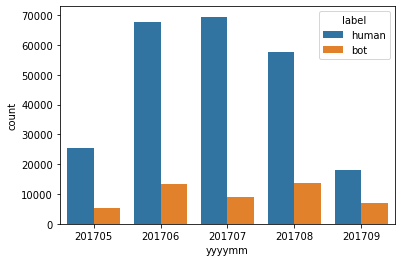

In [12]:
df['yyyymm'] = df['created_at'].apply(lambda x: x[:4]+x[5:7])
ax = sns.countplot(x="yyyymm", hue="label", data=df)

Dataset for classification task

In [13]:
filepath = os.path.join(save_dir, 'tweets_imbalanced_{}.csv'.format(len(df)))
df.to_csv(filepath, index=False)
print('Created {}'.format(filepath))

Created /media/dmlab/My Passport/DATA/fin_tweet_spam/data/tweets_imbalanced_286399.csv
